In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
label_map_path = os.path.join("..", "data", "gleason-grading", "label-map.json")

with open(label_map_path, "r") as f: label_map = json.load(f)

label_map

{'Normal': 0, 'Stroma': 1, 'G3': 2, 'G4': 3, 'G5': 4}

In [3]:
perturbation_type = "brightness"
data_dir = os.path.join("..", "results", "gleason-grading", "uni", "perturbations")

table_dir = os.path.join(data_dir, perturbation_type)
tables = os.listdir(table_dir)
tables.sort(key=lambda x: float(Path(x).stem.split("_")[-1]))

tables[:5]

['brightness_-1.0.parquet',
 'brightness_-0.8.parquet',
 'brightness_-0.6.parquet',
 'brightness_-0.4.parquet',
 'brightness_-0.2.parquet']

In [4]:
table_paths = [os.path.join(table_dir, f) for f in tables]

table_paths[:5]

['../results/gleason-grading/uni/perturbations/brightness/brightness_-1.0.parquet',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.8.parquet',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.6.parquet',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.4.parquet',
 '../results/gleason-grading/uni/perturbations/brightness/brightness_-0.2.parquet']

In [5]:
test = pd.read_parquet(table_paths[1])

test.head()

,loss,confidence_score,prediction,target,file_key
0,0.099698,"[7.256253e-05, 8.536365e-05, 0.90511084, 0.094...",2,2,0
1,0.068584,"[0.00018892482, 0.00058738695, 0.9337148, 0.06...",2,2,1
2,0.136943,"[8.0785525e-05, 0.00042149375, 0.87202007, 0.1...",2,2,2
3,0.025731,"[4.7733232e-05, 2.264722e-06, 0.9745969, 0.025...",2,2,3
4,0.016076,"[0.00013522158, 3.0866922e-06, 0.98405266, 0.0...",2,2,4


In [6]:
test.apply(lambda x: x["confidence_score"][x["target"]], axis=1)

0         0.905111
1         0.933715
2         0.872020
3         0.974597
4         0.984053
            ...   
373721    0.882204
373722    0.652176
373723    0.784780
373724    0.278460
373725    0.936980
Length: 373726, dtype: float32

In [7]:
def get_metrics(table_paths):
    confidence_scores = []
    aug_strengths = []

    for table_path in tqdm(table_paths, desc="Extracting Metrics"):
        if np.equal(float(Path(table_path).stem.split("_")[-1]), 0):
            aug_strength = "base"
        
        else:
            aug_strength = float(Path(table_path).stem.split("_")[-1])
        
        df = pd.read_parquet(table_path)

        confidence = df.apply(lambda x: x["confidence_score"][x["target"]], axis=1).mean()
        
        confidence_scores.append(confidence)
        aug_strengths.append(aug_strength)

    return confidence_scores, aug_strengths

In [8]:
confidence_scores, aug_strengths = get_metrics(table_paths)

Extracting Metrics: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


In [9]:
results_table = {
    "avg_confidence": confidence_scores,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)

df_agg.head()

,avg_confidence,aug_strengths
0,0.179226,-1.0
1,0.776487,-0.8
2,0.762753,-0.6
3,0.765132,-0.4
4,0.765206,-0.2


In [10]:
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

,avg_confidence,aug_strengths
0,0.179226,-1.0
1,0.776487,-0.8
2,0.762753,-0.6
3,0.765132,-0.4
4,0.765206,-0.2


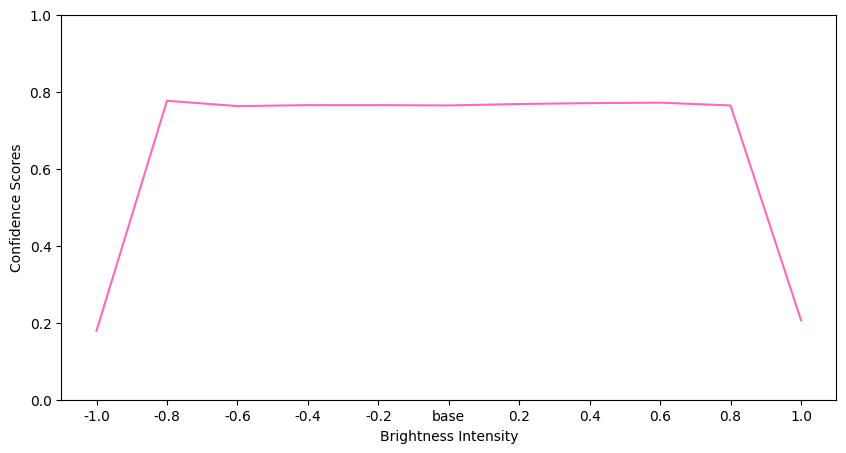

In [11]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

sns.lineplot(df_agg, y="avg_confidence", x="aug_strengths", color=colors[0])

plt.ylabel("Confidence Scores", fontsize=10)
plt.xlabel("Brightness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)
# plt.xticks(rotation=45)

plt.show()

In [12]:
df_agg.head(6).iloc[::-1]

,avg_confidence,aug_strengths
5,0.764357,base
4,0.765206,-0.2
3,0.765132,-0.4
2,0.762753,-0.6
1,0.776487,-0.8
0,0.179226,-1.0


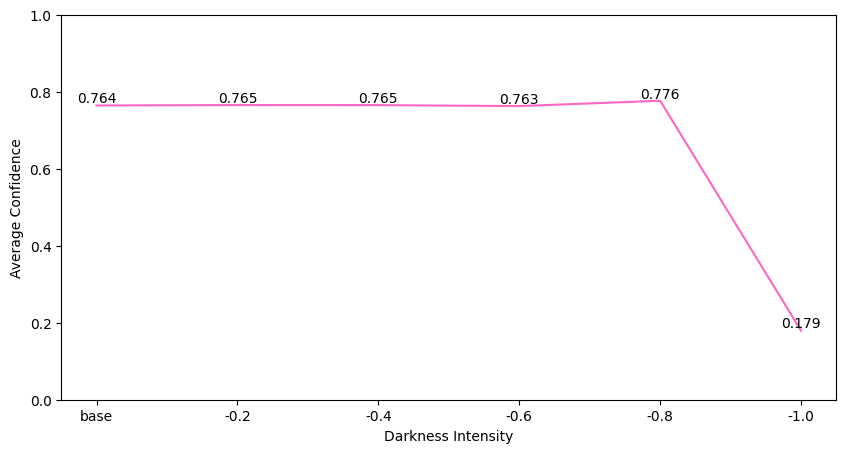

In [13]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

ax = sns.lineplot(df_agg.head(6).iloc[::-1], y="avg_confidence", x="aug_strengths", color=colors[0])

plt.ylabel("Average Confidence", fontsize=10)
plt.xlabel("Darkness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["avg_confidence"]):
    plt.text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

plt.show()

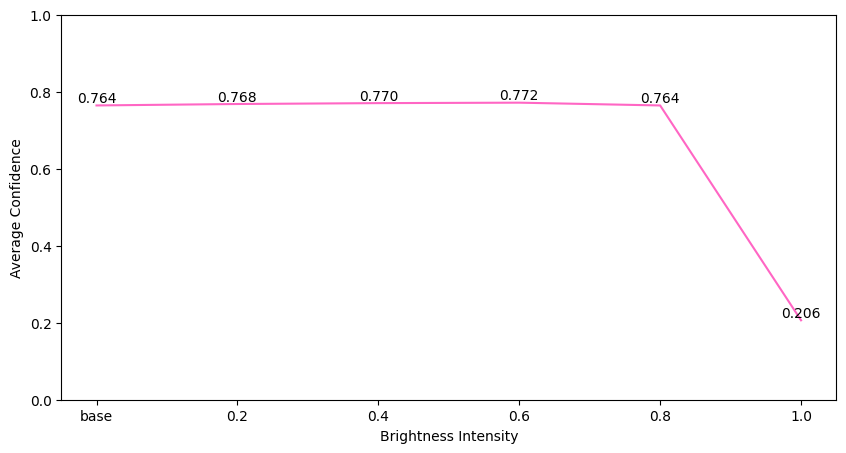

In [14]:
colors = ["#ff66c4"]

plt.figure(figsize=(10, 5))

ax = sns.lineplot(df_agg.tail(6), y="avg_confidence", x="aug_strengths", color=colors[0])

plt.ylabel("Average Confidence", fontsize=10)
plt.xlabel("Brightness Intensity", fontsize=10)

plt.ylim(0.0, 1.0)

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["avg_confidence"]):
    plt.text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

plt.show()

In [15]:
df_agg.tail(6)

,avg_confidence,aug_strengths
5,0.764357,base
6,0.768100,0.2
7,0.770386,0.4
8,0.771562,0.6
9,0.764338,0.8
10,0.206254,1.0


## Per class analysis

In [16]:
def get_filtered_metrics(table_paths, target):
    confidence_scores = []
    aug_strengths = []

    for table_path in tqdm(table_paths, desc="Extracting Metrics"):
        if np.equal(float(Path(table_path).stem.split("_")[-1]), 0):
            aug_strength = "base"
        
        else:
            aug_strength = float(Path(table_path).stem.split("_")[-1])
        
        df = pd.read_parquet(table_path)
        df = df[df["target"] == target]

        avg_confidence = df.apply(lambda x: x["confidence_score"][x["target"]], axis=1).mean()
        
        confidence_scores.append(avg_confidence)
        aug_strengths.append(aug_strength)

    return confidence_scores, aug_strengths

## Normal

In [17]:
label = "Normal"

target = label_map[label]

confidence_scores, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "avg_confidence": confidence_scores,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]


,avg_confidence,aug_strengths
0,0.491001,-1.0
1,0.774202,-0.8
2,0.679070,-0.6
3,0.773363,-0.4
4,0.785257,-0.2


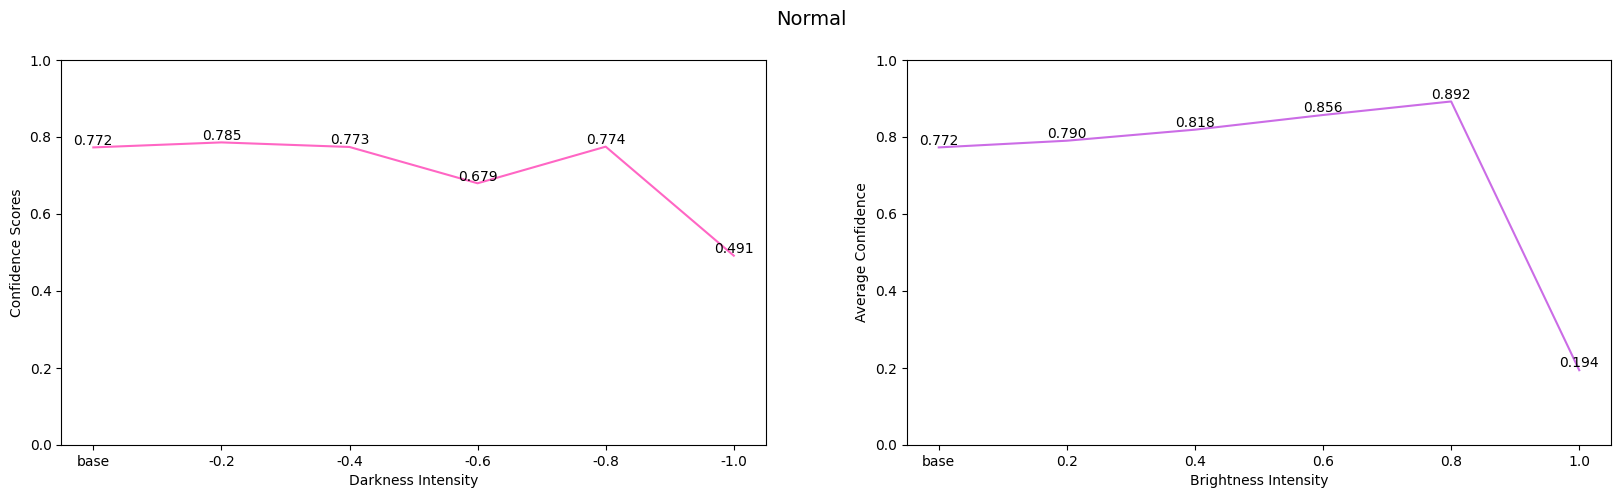

In [18]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="avg_confidence", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["avg_confidence"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Confidence Scores", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="avg_confidence", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["avg_confidence"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Average Confidence", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

## Stroma

In [19]:
label = "Stroma"

target = label_map[label]

confidence_scores, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "avg_confidence": confidence_scores,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]


,avg_confidence,aug_strengths
0,0.050501,-1.0
1,0.902422,-0.8
2,0.883549,-0.6
3,0.884908,-0.4
4,0.886036,-0.2


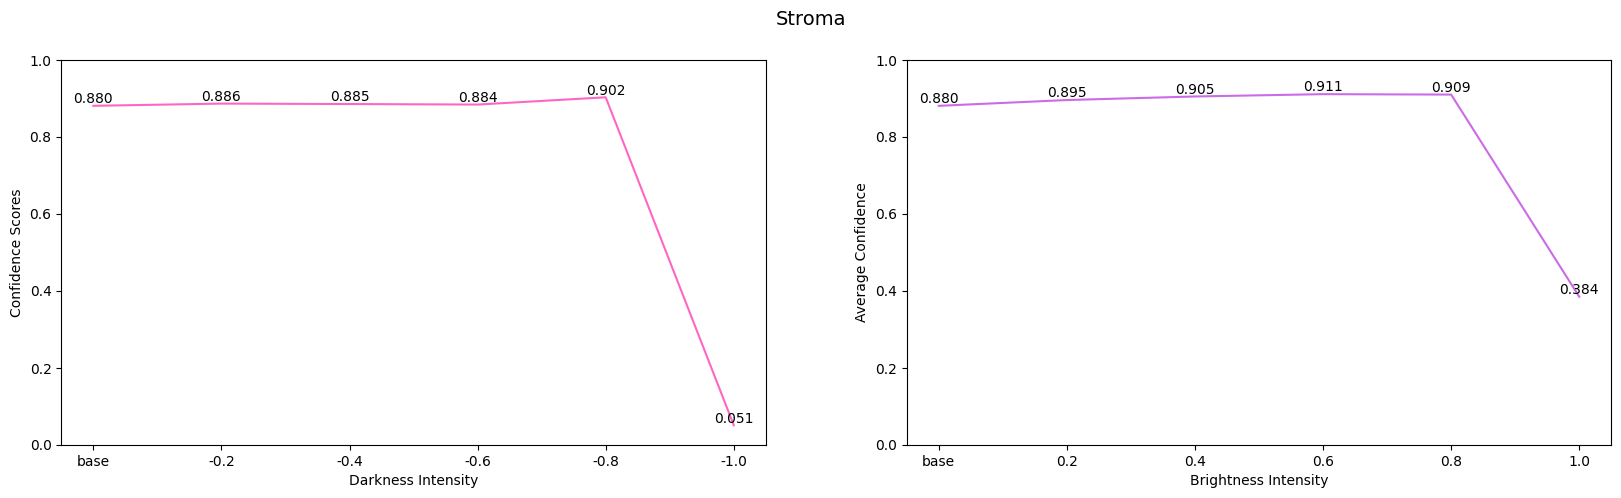

In [20]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="avg_confidence", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["avg_confidence"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Confidence Scores", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="avg_confidence", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["avg_confidence"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Average Confidence", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

## G3

In [21]:
label = "G3"

target = label_map[label]

confidence_scores, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "avg_confidence": confidence_scores,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


,avg_confidence,aug_strengths
0,0.222956,-1.0
1,0.751623,-0.8
2,0.759969,-0.6
3,0.707910,-0.4
4,0.705616,-0.2


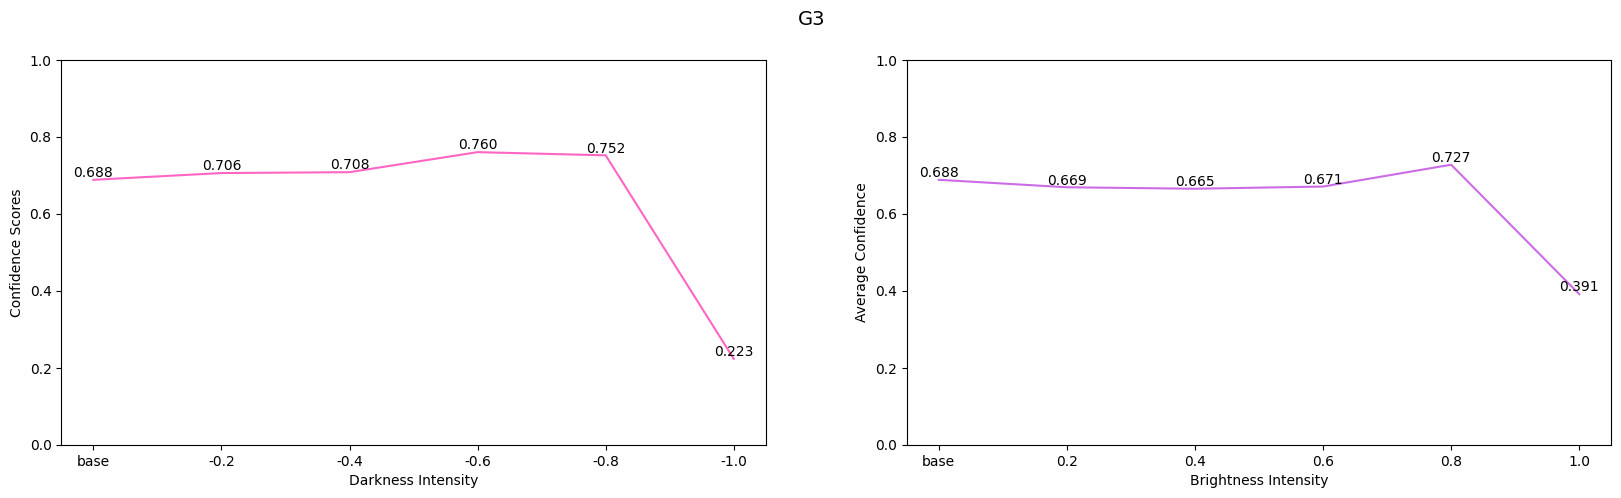

In [22]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="avg_confidence", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["avg_confidence"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Confidence Scores", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="avg_confidence", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["avg_confidence"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Average Confidence", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

## G4

In [23]:
label = "G4"

target = label_map[label]

confidence_scores, aug_strengths = get_filtered_metrics(table_paths, target=target)

results_table = {
    "avg_confidence": confidence_scores,
    "aug_strengths": aug_strengths
}

df_agg = pd.DataFrame(results_table)
df_agg["aug_strengths"] = df_agg["aug_strengths"].map(lambda x: str(x))

df_agg.head()

Extracting Metrics: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]


,avg_confidence,aug_strengths
0,0.098911,-1.0
1,0.789147,-0.8
2,0.782836,-0.6
3,0.776419,-0.4
4,0.771934,-0.2


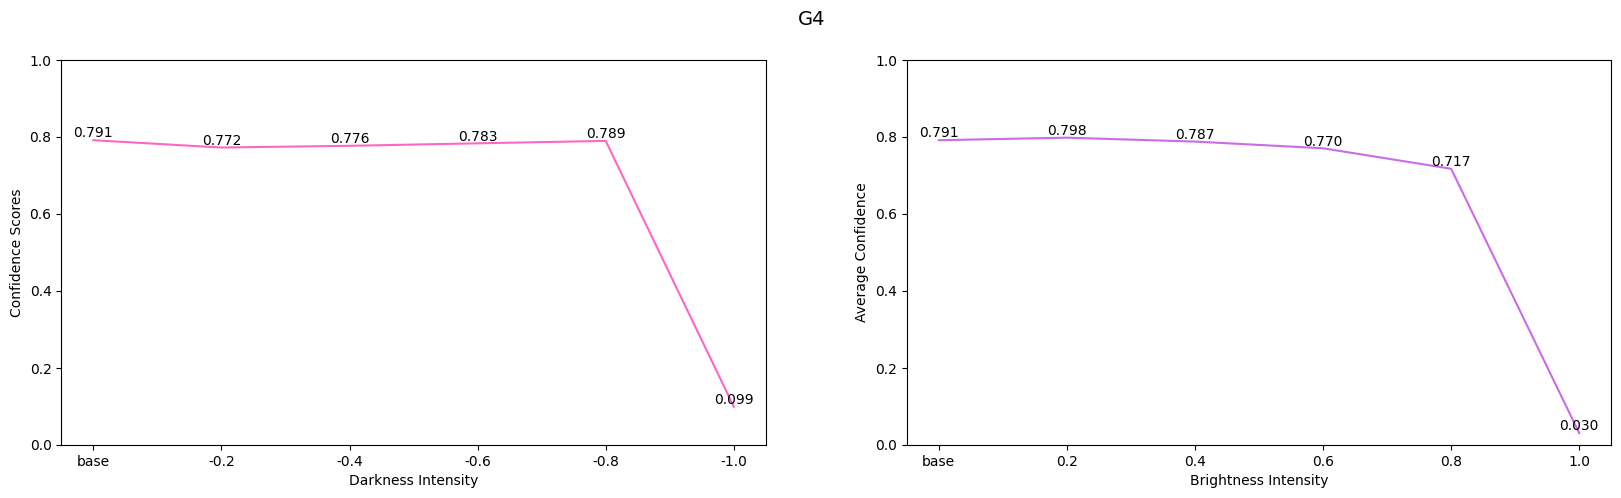

In [24]:
colors = ["#ff66c4", "#cb6ce6"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

fig.suptitle(label, fontsize=14)

# axes 0 - darkness
sns.lineplot(df_agg.head(6).iloc[::-1], y="avg_confidence", x="aug_strengths", color=colors[0], ax=axes[0])

for x, y in zip(df_agg.head(6).iloc[::-1]["aug_strengths"], df_agg.head(6).iloc[::-1]["avg_confidence"]):
    axes[0].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[0].set_ylabel("Confidence Scores", fontsize=10)
axes[0].set_xlabel("Darkness Intensity", fontsize=10)
axes[0].set_ylim(0.0, 1.0)

# axes 1 - brightness
ax = sns.lineplot(df_agg.tail(6), y="avg_confidence", x="aug_strengths", color=colors[1], ax=axes[1])

for x, y in zip(df_agg.tail(6)["aug_strengths"], df_agg.tail(6)["avg_confidence"]):
    axes[1].text(x, y, f"{y:.3f}", fontsize=10, ha="center", va="bottom")

axes[1].set_ylabel("Average Confidence", fontsize=10)
axes[1].set_xlabel("Brightness Intensity", fontsize=10)
axes[1].set_ylim(0.0, 1.0)

plt.show()

In [34]:
dfs = []

for f in tqdm(table_paths, desc="Processing Tables"):
    df = pd.read_parquet(f)
    df["aug_strength"] = [Path(f).stem.split("_")[-1] for _ in range(len(df))]

    dfs.append(df)

concatenated = pd.concat(dfs, axis=0)
concatenated["confidence_score"] = concatenated.apply(lambda x: x["confidence_score"][x["target"]], axis=1)

Processing Tables: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


In [35]:
label_map_reversed = {v: k for k, v in label_map.items()}
concatenated["prediction"] = concatenated["prediction"].map(lambda x: label_map_reversed[x])
concatenated["target"] = concatenated["target"].map(lambda x: label_map_reversed[x])

concatenated.head()

,loss,confidence_score,prediction,target,file_key,aug_strength
0,1.500781,0.222956,Normal,G3,0,-1.0
1,1.500781,0.222956,Normal,G3,1,-1.0
2,1.500781,0.222956,Normal,G3,2,-1.0
3,1.500781,0.222956,Normal,G3,3,-1.0
4,1.500781,0.222956,Normal,G3,4,-1.0


In [36]:
extreme_darkness = concatenated[concatenated["aug_strength"] == "-1.0"]

extreme_darkness.groupby(["target"])["confidence_score"].mean()

target
G3        0.222956
G4        0.098911
G5        0.136631
Normal    0.491001
Stroma    0.050500
Name: confidence_score, dtype: float32

In [37]:
extreme_brightness = concatenated[concatenated["aug_strength"] == "1.0"]

extreme_brightness.groupby(["target"])["confidence_score"].mean()

target
G3        0.391046
G4        0.029937
G5        0.001114
Normal    0.193539
Stroma    0.384364
Name: confidence_score, dtype: float32

In [38]:
concatenated.groupby(["aug_strength", "prediction"]).size()

aug_strength  prediction
-0.0          G3             83263
              G4            156162
              G5              5829
              Normal         54747
              Stroma         73725
-0.2          G3             86508
              G4            150218
              G5              7030
              Normal         55769
              Stroma         74201
-0.4          G3             87071
              G4            151257
              G5              6419
              Normal         54744
              Stroma         74235
-0.6          G3             98531
              G4            151702
              G5              2661
              Normal         47148
              Stroma         73684
-0.8          G3             93501
              G4            150900
              G5               390
              Normal         52672
              Stroma         76263
-1.0          Normal        373726
0.2           G3             79056
              G4            15

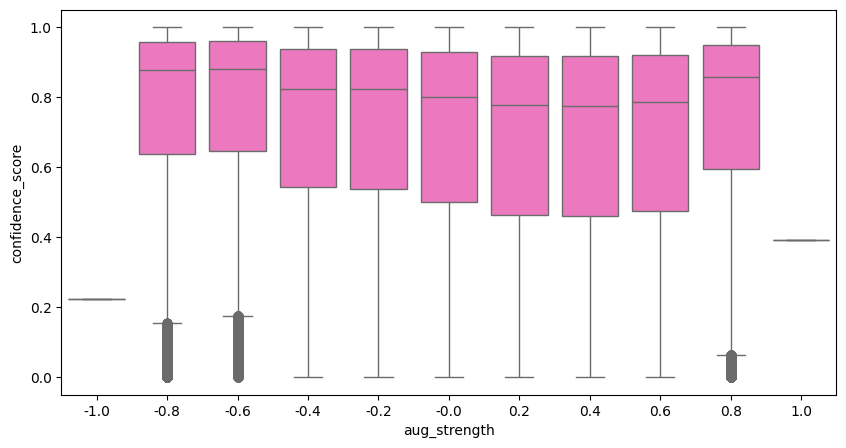

In [47]:
colors = ["#ff66c4", "#cb6ce6"]

plt.figure(figsize=(10, 5))

sns.boxplot(data=concatenated[concatenated["target"] == "G3"], x="aug_strength", y="confidence_score", color=colors[0])

plt.show()

In [44]:
concatenated

,loss,confidence_score,prediction,target,file_key,aug_strength
0,1.500781,0.222956,Normal,G3,0,-1.0
1,1.500781,0.222956,Normal,G3,1,-1.0
2,1.500781,0.222956,Normal,G3,2,-1.0
3,1.500781,0.222956,Normal,G3,3,-1.0
4,1.500781,0.222956,Normal,G3,4,-1.0
...,...,...,...,...,...,...
373721,0.956166,0.384364,G3,Stroma,373724,1.0
373722,0.956166,0.384364,G3,Stroma,373725,1.0
373723,0.956166,0.384364,G3,Stroma,373726,1.0
373724,0.956166,0.384364,G3,Stroma,373727,1.0
